<a href="https://colab.research.google.com/github/ed765super/Assignment-8-Ensembles/blob/main/DATA602_Assignment_8_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions
Using attached file: flight-data.csv


Analyze the data and create a processing pipeline. We are interested if we can predict whether a flight gets delayed or not (arr_delay).

Fit a logistic regression, decision tree, and SVM using grid search. 

Discuss the performance of each model.

Fit an ensemble using the three above models. Does this improvement performance?

Fit a model using AdaBoost. Does this improve performance?


Submit a link to the GitHub repo where you post the notebook.

#Get Data

In [10]:
import pandas as pd
import numpy as np
df = pd.read_csv('flight-data.csv')

df

,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,type,manufacturer,model,engines,seats,engine,arr_delay
0,B6,1201,N643JB,JFK,FLL,135.0,1069,21,50,73.04,66.92,81.14,160.0,13.80936,19.56326,0.0,1019.4,10.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,1.0
1,DL,1773,N3743H,JFK,LAS,287.0,2248,15,35,71.06,42.98,36.28,230.0,14.96014,NaN,0.0,1020.4,10.0,Fixed wing multi engine,BOEING,737-832,2.0,189.0,Turbo-jet,0.0
2,EV,4572,N11107,EWR,GSP,84.0,594,15,9,78.80,69.80,73.95,200.0,8.05546,NaN,0.0,NaN,5.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,Turbo-fan,1.0
3,B6,179,N526JB,JFK,PHX,305.0,2153,17,35,44.06,14.00,29.23,270.0,17.26170,24.16638,0.0,1009.2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,US,1733,N162UW,LGA,CLT,78.0,544,7,53,69.98,53.96,56.78,230.0,6.90468,NaN,0.0,1021.3,10.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A321-211,2.0,199.0,Turbo-jet,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,UA,535,N525UA,JFK,LAX,323.0,2475,18,35,48.92,15.98,26.52,360.0,8.05546,NaN,0.0,1025.3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9996,DL,1147,N977DL,LGA,ATL,106.0,762,20,0,75.02,57.92,55.28,190.0,13.80936,NaN,0.0,1017.3,10.0,Fixed wing multi engine,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,2.0,142.0,Turbo-fan,1.0
9997,EV,4204,N12163,EWR,OKC,NaN,1325,20,9,37.04,33.98,88.57,240.0,9.20624,NaN,0.0,1017.0,9.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2.0,55.0,Turbo-fan,NaN
9998,B6,431,N585JB,LGA,SRQ,146.0,1047,13,30,35.96,19.94,51.78,280.0,9.20624,18.41248,0.0,1016.9,10.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,1.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carrier       10000 non-null  object 
 1   flight        10000 non-null  int64  
 2   tailnum       9926 non-null   object 
 3   origin        10000 non-null  object 
 4   dest          10000 non-null  object 
 5   air_time      9716 non-null   float64
 6   distance      10000 non-null  int64  
 7   hour          10000 non-null  int64  
 8   minute        10000 non-null  int64  
 9   temp          9952 non-null   float64
 10  dewp          9952 non-null   float64
 11  humid         9952 non-null   float64
 12  wind_dir      9731 non-null   float64
 13  wind_speed    9951 non-null   float64
 14  wind_gust     2387 non-null   float64
 15  precip        9954 non-null   float64
 16  pressure      8808 non-null   float64
 17  visib         9954 non-null   float64
 18  type          8499 non-null

#Analyze the data and create a processing pipeline.

In [4]:
#First we'll check for NA values
df.isna().sum()

carrier            0
flight             0
tailnum           74
origin             0
dest               0
air_time         284
distance           0
hour               0
minute             0
temp              48
dewp              48
humid             48
wind_dir         269
wind_speed        49
wind_gust       7613
precip            46
pressure        1192
visib             46
type            1501
manufacturer    1501
model           1501
engines         1501
seats           1501
engine          1501
arr_delay        284
dtype: int64

Seems to have a solid amount of NA values, so an imputter will be needed.

Now to check what our target column looks like

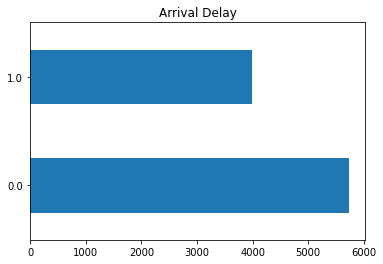

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
df.arr_delay.value_counts().plot.barh()
plt.title('Arrival Delay')
plt.show()

There's a minor amount of unbalance.

Now I am going to check the cardinality of the data to see whether I need to modify my pipeline to take into account multicardinality issues

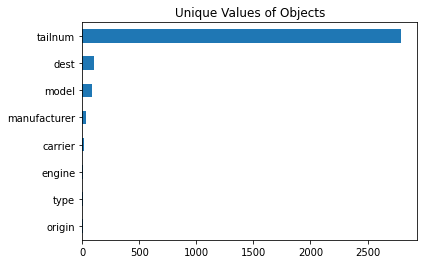

origin             3
type               3
engine             6
carrier           16
manufacturer      28
model             86
dest             101
tailnum         2795
dtype: int64

In [9]:
df.select_dtypes('object').nunique().sort_values().plot.barh()
plt.title('Unique Values of Objects')
plt.show()

df.select_dtypes('object').nunique().sort_values()

tailnum seems to be similar to an indexing variable so i will need to chop that off.

Now to check the various numerical variables to see whether they are uniform or skewed

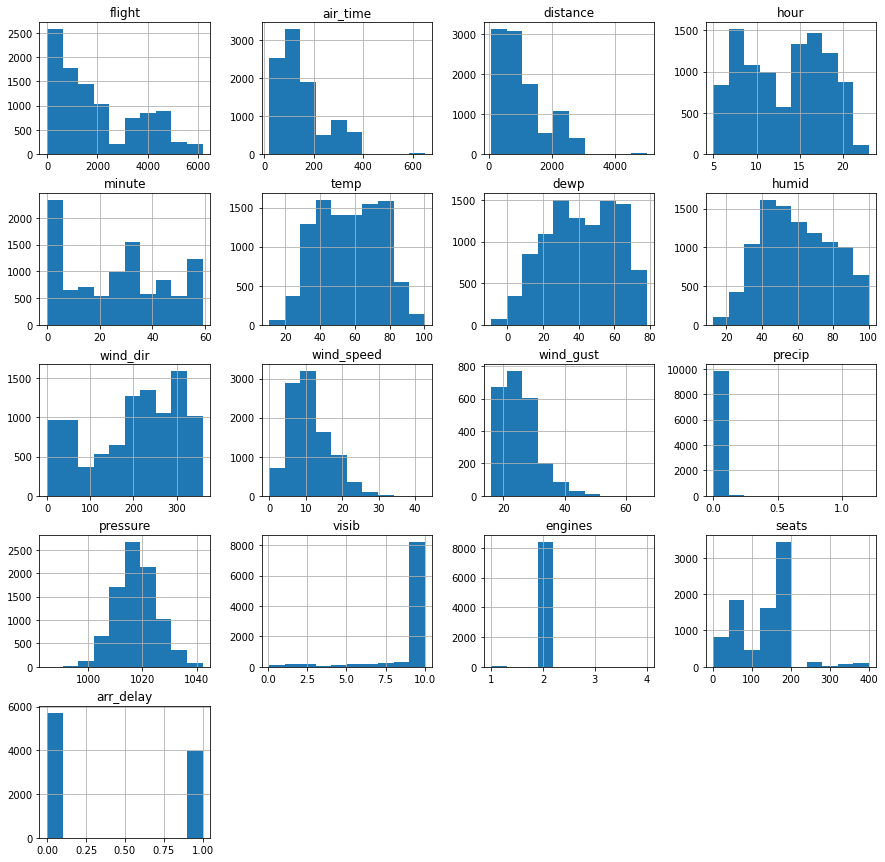

In [22]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (15,15)
df.select_dtypes(['int64','float64']).hist()
plt.show()

wind speed, wind gust,flight, air time, and distance seem to be skewed in one way or another
visibility seems to be mostly 10s
There seems to be at most 2 engines in each plane most days seem to be clear

#Fit a logistic regression, decision tree, and SVM using grid search.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#First grab all the columns and put em in lists
nums = df.dtypes[df.dtypes != 'object'].index.tolist()
cats = df.dtypes[df.dtypes == 'object'].index.tolist()

#Now remove the columns I dont think I need
cats = [x for x in cats if x not in ['tailnum']]

num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, nums),
                                                      ('create_dummies', cat_pipeline, cats)])

print('Pipeline Created')

Pipeline Created


Splitting the data

In [25]:
from sklearn.model_selection import train_test_split

tX_train, tX_test, ty_train, ty_test = train_test_split(df[nums+cats], df["arr_delay"], test_size=0.25)

print(f'Training examples: {tX_train.shape[0]:,}')
print(f'Test examples: {tX_test.shape[0]:,}')

Training examples: 7,500
Test examples: 2,500


Logistic Regression with grid search

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p1 = Pipeline([('processing', processing_pipeline),
             ('lr', LogisticRegression(solver='liblinear'))])

#Select various correlation strengths with a magnitude of 10
params = {'lr__C': [.001, 0.01, 0.1, 1, 10, 100]}

#I will score based on accurancy as that the dataset is not heavily skewed
lr_gscv = GridSearchCV(p1, param_grid=params, cv=10, scoring='accuracy', refit=True)
lr_gscv = lr_gscv.fit(tX_train, ty_train)

print(f'Validation score: {lr_gscv.best_score_:.2%}')

lr_pred = lr_gscv.predict(tX_test)

print(f'Test score: {lr_gscv.score(tX_test, ty_test):.2%}')

ValueError: ignored

Descision Trees

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

p2 = Pipeline([('processing', processing_pipeline),
             ('dt', DecisionTreeClassifier())])

params = {'dt__max_depth': [1, 5, 10, 15, 25],
         'dt__min_samples_split': [3, 10, 15]}

dt_gscv = GridSearchCV(p2, param_grid=params, cv=10, scoring='accuracy', refit=True)
dt_gscv = dt_gscv.fit(tX_train, ty_train)

print(f'Validation score: {dt_gscv.best_score_:.2%}')

dt_pred = dt_gscv.predict(tX_test)

print(f'Test score: {dt_gscv.score(tX_test, ty_test):.2%}')

SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

svm_m = modeling_pipeline = Pipeline([('scaling', StandardScaler()),
                                       ('model', SVC())])


param_grid = [
  {'model__C': [0.01, 0.1, 1, 10, 100, 1000], 'model__kernel': ['linear','rbf']}
 ]

svm_results = GridSearchCV(estimator=svm_m, param_grid=param_grid, cv=10, scoring='accuracy', refit=True)
svm_results = svm_results.fit(dX_train, dy_train)

print(f'Validation score: {svm_results.best_score_:.2%}')

svm_pred = svm_results.predict(tX_test)

print(f'Test score: {svm_results.score(tX_test, ty_test):.2%}')

#Discuss the performance of each model.

#Fit an ensemble using the three above models. Does this improvement performance?

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
clf3 = svm.SVC()

pipe1 = Pipeline([('scaler', StandardScaler()),('logreg', clf1)])
pipe2 = Pipeline([('scaler', StandardScaler()),('tree', clf2)])
pipe3 = Pipeline([('scaler', StandardScaler()),('svm', clf3)])

labs = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine']
clfs = [pipe1, pipe2, pipe3]
clfs = zip(labs, clfs)

for lab, clf in clfs:
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print(f'Accuracy {scores.mean():.2f} (+/- {scores.std():.2f}) [{lab}]')

In [ ]:
from sklearn.ensemble import VotingClassifier

ems = [('lr', pipe1),('dt', pipe2),('svm', pipe3)]
clf4 = VotingClassifier(estimators= ems, weights=None, voting='soft')

scores = cross_val_score(estimator=clf4, X=X_train, y=y_train, cv=10, scoring='accuracy')
print(f'Accuracy {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')

#Fit a model using AdaBoost. Does this improve performance?

ADA BOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# multi-step pipelines don't play as nice with AdaBoost
xt = processing_pipeline.fit_transform(tX_train)

params = {'base_estimator__max_depth': [1,2],
         'n_estimators': [50, 100, 200, 400]
         }

#ABC = AdaBoostClassifier(base_estimator=p2)
ABC = AdaBoostClassifier(DecisionTreeClassifier())


ad_gscv = GridSearchCV(ABC, param_grid = params, cv=10, scoring='accuracy')
           
ad_gscv = ad_gscv.fit(xt, ty_train)

print(f'Validation score: {ad_gscv.best_score_:.2%}')

xtt = processing_pipeline.transform(tX_test)

ad_pred = ad_gscv.predict(xtt)

print(f'Test score: {ad_gscv.score(xtt, ty_test):.2%}')